# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-face-generation/problem_unittests.py

--2020-07-18 03:30:33--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-face-generation/problem_unittests.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2113 (2.1K) [text/plain]
Saving to: ‘problem_unittests.py’

problem_unittests.p 100%[===================>]   2.06K  --.-KB/s    in 0s      

2020-07-18 03:30:33 (34.4 MB/s) - ‘problem_unittests.py’ saved [2113/2113]



In [2]:
data_dir = '/kaggle/input/processed-celeba-small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir=data_dir):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    # Define dataset using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)
    
    # Create and return trainloader
    trainloder = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    
    return trainloder


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

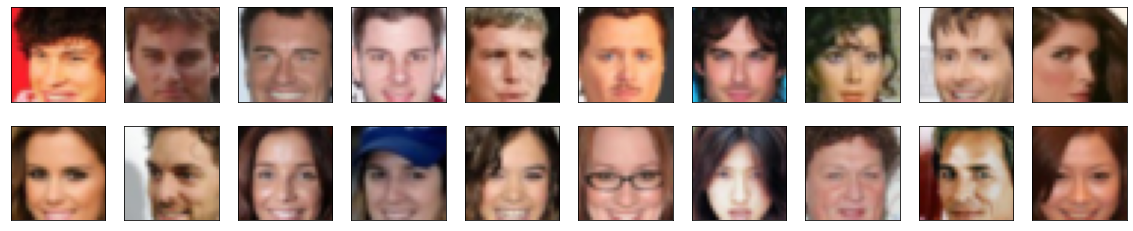

In [11]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [12]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# Helper function 
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
     :param in_channels: number of input for a convolutional layer
     :param out_channels: number of output for a convolutional layer
     :param kernel_size: size of filter
     :param stride: the amount of pixels the filters move while scanning the image
     :param padding: how many pixels to pad an image with
     :param batch_norm: choose whether to implement batch normalization or not
     :return: list of convoluyional layers with or without batch normalization
    """

    layers = []
    
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                               kernel_size, stride=stride, padding=padding, bias=False)
        
    # Append conv layer
    layers.append(conv_layer)
        
    if batch_norm:
        # Append batch normalization layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    # Return the layers using squnetial container
    return nn.Sequential(*layers)
        

In [16]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # Define the layers
        self.conv1 = conv(3, conv_dim, kernel_size=4, batch_norm=False) # output 16X16X32        
        
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4) # output 8X8X64
        
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4) # output 4X4X128
        
        self.conv4 = conv(conv_dim*4, conv_dim*8, kernel_size=4) # output 2X2X256
        
        self.conv5 = conv(conv_dim*8, conv_dim*16, kernel_size=4) # output 1X1X512
        
        # Define a dropout layer
        self.dropout = nn.Dropout2d(0.2)
        # The final fully connected layer
        self.fc = nn.Linear((conv_dim*16)*1, 1)

        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x))
        out = F.leaky_relu(self.conv2(out))
        out = F.leaky_relu(self.conv3(out))
        out = F.leaky_relu(self.conv4(out))
        out = F.leaky_relu(self.conv5(out))
        
        # Flatten the output and pass it through the final layer
        out = out.view(-1, (self.conv_dim*16)*1)
        # Return the logits
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [17]:
# Helper function for transpose convolutional layer
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    """Creates a transposed-convolutional layer, with optional batch normalization.
     :param in_channels: number of input for a convolutional layer
     :param out_channels: number of output for a convolutional layer
     :param kernel_size: size of filter
     :param stride: the amount of pixels the filters move while scanning the image
     :param padding: how many pixels to pad an image with
     :param batch_norm: choose whether to implement batch normalization or not
     :return: list of convoluyional transpose layers with or without batch normalization
    """
    layers = []
        
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                          kernel_size=4, bias=False, stride=stride, padding=padding)
        
    # Append to layers
    layers.append(deconv_layer)
     
    if batch_norm:
        # Append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    # Retun layers using squential container
    return nn.Sequential(*layers)    
        

In [18]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # Define the first fully connected layer
        self.fc = nn.Linear(z_size, conv_dim*16*1)
        
        # Define the tanspose convolutional layers
        self.t_conv1 = deconv(conv_dim*16, conv_dim*8, kernel_size=4) # output 2X2X256
        
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4, kernel_size=4) # output 4X4X128
        
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2, kernel_size=4) # output 8X8X64
        
        self.t_conv4 = deconv(conv_dim*2, conv_dim, kernel_size=4) # output 16X16X32
        
        self.t_conv5 = deconv(conv_dim, 3, kernel_size=4, batch_norm=False) # output 32X32X3 
        
        
        
       
          # Define a dropout layer
        #self.dropout = nn.Dropout2d(0.5)  
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*16, 1, 1) # Reshape to (batch_size, depth, 1, 1)
        
        out =  F.relu(self.t_conv1(out))
        out =  F.relu(self.t_conv2(out))
        out =  F.relu(self.t_conv3(out))
        out =  F.relu(self.t_conv4(out))
        out =  self.t_conv5(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [19]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    # for every Linear and a convolutional layer in a model
    if classname.find('Conv') != -1:  
         nn.init.xavier_normal_(m.weight.data)

    elif classname.find('Linear') != -1:
        # mean = 0 and standard deviation = 0.02
         nn.init.xavier_normal_(m.weight.data)

    ##elif classname.find('BatchNorm2d') != -1:
        ##nn.init.normal_(m.weight.data, 1.0, 0.02)
        
    if hasattr(m, 'bias') and m.bias is not None:
                 m.bias.data.fill_(0.0)
        

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [21]:
# Define model hyperparams
d_conv_dim = 32 
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc):

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [23]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    # Move thew labels to GPU
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

# Updating the Learning Rate by Implementing Schedualer

reference: 
https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee

In [24]:
from torch.optim.lr_scheduler import LambdaLR

# reference
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda



In [46]:
import torch.optim as optim
import math
# cyclical lr options
factor = 10
max_lr = 0.001
min_lr = max_lr
# hyperparams for Adam optimizers

#lr= 0.0002
beta1= 0.5
beta2= 0.999 
beta_1 = 0.5
beta_2 = 0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), 1., [beta_1, beta_2])
g_optimizer = optim.Adam(G.parameters(), 1., [beta_1, beta_2])

step_size = 4*len(celeba_train_loader)
clr = cyclical_lr(step_size, min_lr=min_lr/factor, max_lr=max_lr)
g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer, [clr])
d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer, [clr])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [47]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            # Train with real images
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            
            d_real_loss = real_loss(D_real, smooth=True)
            
            # Train with fake images
            # Generate with fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # Move to GPU
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # Update the learning rate
            d_scheduler.step()
            lr_d_sched_last = d_scheduler.get_last_lr()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images 
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # Move to GPU
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute loss for fake images using flipped labels
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            # Update the learning rate
            g_scheduler.step()
            lr_g_sched_last = g_scheduler.get_last_lr()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================
            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f} | lr: {}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item(), lr_g_sched_last))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
    
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [48]:
# set number of epochs 
n_epochs = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.4766 | g_loss: 0.7991 | lr: [5.0168918918918996e-05]
Epoch [    1/   30] | d_loss: 1.3670 | g_loss: 0.8487 | lr: [5.86148648648648e-05]
Epoch [    1/   30] | d_loss: 1.2990 | g_loss: 0.9455 | lr: [6.706081081081082e-05]
Epoch [    1/   30] | d_loss: 1.0183 | g_loss: 1.1643 | lr: [7.550675675675685e-05]
Epoch [    1/   30] | d_loss: 0.8881 | g_loss: 1.4193 | lr: [8.395270270270265e-05]
Epoch [    1/   30] | d_loss: 0.6875 | g_loss: 1.5852 | lr: [9.239864864864867e-05]
Epoch [    1/   30] | d_loss: 0.8493 | g_loss: 1.5475 | lr: [0.0001008445945945947]
Epoch [    1/   30] | d_loss: 0.7565 | g_loss: 1.6545 | lr: [0.0001092905405405405]
Epoch [    1/   30] | d_loss: 0.5356 | g_loss: 2.0003 | lr: [0.00011773648648648652]
Epoch [    1/   30] | d_loss: 0.5555 | g_loss: 2.0898 | lr: [0.00012618243243243233]
Epoch [    1/   30] | d_loss: 0.5268 | g_loss: 2.3272 | lr: [0.00013462837837837835]
Epoch [    1/   30] | d_loss: 0.9336 | g_loss: 2.3363 | lr: [0.0001430743

Epoch [    4/   30] | d_loss: 0.5736 | g_loss: 3.1229 | lr: [0.0008555743243243243]
Epoch [    4/   30] | d_loss: 0.5879 | g_loss: 3.0739 | lr: [0.0008640202702702704]
Epoch [    4/   30] | d_loss: 0.4596 | g_loss: 3.4918 | lr: [0.0008724662162162162]
Epoch [    4/   30] | d_loss: 0.5535 | g_loss: 3.1578 | lr: [0.000880912162162162]
Epoch [    4/   30] | d_loss: 0.8068 | g_loss: 4.2216 | lr: [0.0008893581081081082]
Epoch [    4/   30] | d_loss: 0.5369 | g_loss: 3.0891 | lr: [0.0008978040540540541]
Epoch [    4/   30] | d_loss: 0.7070 | g_loss: 4.7875 | lr: [0.0009062499999999999]
Epoch [    4/   30] | d_loss: 0.7755 | g_loss: 3.4553 | lr: [0.0009146959459459461]
Epoch [    4/   30] | d_loss: 0.9714 | g_loss: 2.4012 | lr: [0.000923141891891892]
Epoch [    4/   30] | d_loss: 1.8918 | g_loss: 4.5663 | lr: [0.0009315878378378377]
Epoch [    4/   30] | d_loss: 0.8158 | g_loss: 2.8927 | lr: [0.0009400337837837838]
Epoch [    4/   30] | d_loss: 0.7820 | g_loss: 3.7545 | lr: [0.000948479729729

Epoch [    7/   30] | d_loss: 0.5814 | g_loss: 3.6206 | lr: [0.00033902027027027024]
Epoch [    7/   30] | d_loss: 0.4459 | g_loss: 4.8138 | lr: [0.0003305743243243242]
Epoch [    7/   30] | d_loss: 0.4579 | g_loss: 2.1674 | lr: [0.0003221283783783784]
Epoch [    7/   30] | d_loss: 0.8793 | g_loss: 3.3755 | lr: [0.0003136824324324324]
Epoch [    7/   30] | d_loss: 0.6468 | g_loss: 3.7481 | lr: [0.0003052364864864866]
Epoch [    7/   30] | d_loss: 0.5022 | g_loss: 2.2615 | lr: [0.00029679054054054056]
Epoch [    7/   30] | d_loss: 0.5868 | g_loss: 3.0227 | lr: [0.00028834459459459454]
Epoch [    8/   30] | d_loss: 0.6829 | g_loss: 3.1509 | lr: [0.000287331081081081]
Epoch [    8/   30] | d_loss: 0.4782 | g_loss: 3.0770 | lr: [0.0002788851351351352]
Epoch [    8/   30] | d_loss: 0.5005 | g_loss: 1.5100 | lr: [0.0002704391891891892]
Epoch [    8/   30] | d_loss: 0.8147 | g_loss: 2.2531 | lr: [0.00026199324324324317]
Epoch [    8/   30] | d_loss: 0.5354 | g_loss: 3.7949 | lr: [0.0002535472

Epoch [   11/   30] | d_loss: 0.6882 | g_loss: 3.1372 | lr: [0.0005589527027027027]
Epoch [   11/   30] | d_loss: 0.4709 | g_loss: 2.5054 | lr: [0.0005673986486486485]
Epoch [   11/   30] | d_loss: 0.4051 | g_loss: 4.0345 | lr: [0.0005758445945945947]
Epoch [   11/   30] | d_loss: 0.6055 | g_loss: 1.6329 | lr: [0.0005842905405405405]
Epoch [   11/   30] | d_loss: 0.4775 | g_loss: 3.9333 | lr: [0.0005927364864864864]
Epoch [   11/   30] | d_loss: 0.7942 | g_loss: 4.6741 | lr: [0.0006011824324324325]
Epoch [   11/   30] | d_loss: 0.5384 | g_loss: 3.4365 | lr: [0.0006096283783783784]
Epoch [   11/   30] | d_loss: 0.4594 | g_loss: 2.9809 | lr: [0.0006180743243243242]
Epoch [   11/   30] | d_loss: 0.8307 | g_loss: 3.7491 | lr: [0.0006265202702702704]
Epoch [   11/   30] | d_loss: 0.5015 | g_loss: 2.8245 | lr: [0.0006349662162162162]
Epoch [   11/   30] | d_loss: 0.4941 | g_loss: 2.9190 | lr: [0.0006434121621621621]
Epoch [   11/   30] | d_loss: 0.5025 | g_loss: 3.8615 | lr: [0.0006518581081

Epoch [   14/   30] | d_loss: 0.5327 | g_loss: 2.9354 | lr: [0.0006356418918918918]
Epoch [   14/   30] | d_loss: 0.5630 | g_loss: 2.7075 | lr: [0.0006271959459459459]
Epoch [   14/   30] | d_loss: 0.5466 | g_loss: 2.8384 | lr: [0.0006187500000000002]
Epoch [   14/   30] | d_loss: 0.4963 | g_loss: 2.6035 | lr: [0.000610304054054054]
Epoch [   14/   30] | d_loss: 0.6878 | g_loss: 3.0786 | lr: [0.0006018581081081081]
Epoch [   14/   30] | d_loss: 0.4643 | g_loss: 5.5668 | lr: [0.0005934121621621623]
Epoch [   14/   30] | d_loss: 0.4042 | g_loss: 4.2581 | lr: [0.0005849662162162161]
Epoch [   14/   30] | d_loss: 0.4271 | g_loss: 3.7151 | lr: [0.0005765202702702702]
Epoch [   14/   30] | d_loss: 0.4378 | g_loss: 3.1090 | lr: [0.0005680743243243245]
Epoch [   14/   30] | d_loss: 0.3935 | g_loss: 5.0712 | lr: [0.0005596283783783783]
Epoch [   14/   30] | d_loss: 0.3852 | g_loss: 3.8040 | lr: [0.0005511824324324324]
Epoch [   14/   30] | d_loss: 0.4470 | g_loss: 4.1982 | lr: [0.00054273648648

Epoch [   17/   30] | d_loss: 0.6713 | g_loss: 5.9197 | lr: [0.0002697635135135134]
Epoch [   17/   30] | d_loss: 0.6761 | g_loss: 4.2130 | lr: [0.00027820945945945965]
Epoch [   17/   30] | d_loss: 0.4058 | g_loss: 5.0912 | lr: [0.0002866554054054051]
Epoch [   18/   30] | d_loss: 0.6692 | g_loss: 3.3240 | lr: [0.000287668918918919]
Epoch [   18/   30] | d_loss: 0.4147 | g_loss: 4.0779 | lr: [0.00029611486486486526]
Epoch [   18/   30] | d_loss: 0.4087 | g_loss: 4.6778 | lr: [0.00030456081081081063]
Epoch [   18/   30] | d_loss: 0.3967 | g_loss: 5.3818 | lr: [0.0003130067567567569]
Epoch [   18/   30] | d_loss: 0.4355 | g_loss: 4.6594 | lr: [0.0003214527027027031]
Epoch [   18/   30] | d_loss: 0.5669 | g_loss: 2.3555 | lr: [0.0003298986486486485]
Epoch [   18/   30] | d_loss: 0.4155 | g_loss: 4.3889 | lr: [0.0003383445945945947]
Epoch [   18/   30] | d_loss: 0.4383 | g_loss: 4.4991 | lr: [0.00034679054054054096]
Epoch [   18/   30] | d_loss: 0.4720 | g_loss: 1.5398 | lr: [0.0003552364

Epoch [   21/   30] | d_loss: 0.4390 | g_loss: 4.8231 | lr: [0.0009322635135135137]
Epoch [   21/   30] | d_loss: 0.6809 | g_loss: 6.8023 | lr: [0.0009238175675675674]
Epoch [   21/   30] | d_loss: 0.5739 | g_loss: 4.4186 | lr: [0.0009153716216216213]
Epoch [   21/   30] | d_loss: 0.4399 | g_loss: 3.2225 | lr: [0.0009069256756756758]
Epoch [   21/   30] | d_loss: 0.3880 | g_loss: 3.1037 | lr: [0.0008984797297297296]
Epoch [   21/   30] | d_loss: 0.4959 | g_loss: 5.5001 | lr: [0.0008900337837837834]
Epoch [   21/   30] | d_loss: 0.4278 | g_loss: 2.7347 | lr: [0.000881587837837838]
Epoch [   21/   30] | d_loss: 0.4303 | g_loss: 5.3866 | lr: [0.0008731418918918917]
Epoch [   21/   30] | d_loss: 0.4637 | g_loss: 3.0313 | lr: [0.0008646959459459464]
Epoch [   21/   30] | d_loss: 0.7523 | g_loss: 5.1941 | lr: [0.0008562500000000001]
Epoch [   21/   30] | d_loss: 0.4105 | g_loss: 4.6969 | lr: [0.000847804054054054]
Epoch [   21/   30] | d_loss: 0.4053 | g_loss: 4.2772 | lr: [0.000839358108108

Epoch [   24/   30] | d_loss: 0.3670 | g_loss: 4.2730 | lr: [0.00012685810810810852]
Epoch [   24/   30] | d_loss: 0.7089 | g_loss: 3.3501 | lr: [0.00011841216216216228]
Epoch [   24/   30] | d_loss: 0.3687 | g_loss: 3.3670 | lr: [0.00010996621621621604]
Epoch [   24/   30] | d_loss: 0.3986 | g_loss: 3.2519 | lr: [0.00010152027027027067]
Epoch [   24/   30] | d_loss: 0.3623 | g_loss: 4.1332 | lr: [9.307432432432443e-05]
Epoch [   24/   30] | d_loss: 0.3668 | g_loss: 3.5906 | lr: [8.46283783783782e-05]
Epoch [   24/   30] | d_loss: 0.3826 | g_loss: 4.9286 | lr: [7.618243243243282e-05]
Epoch [   24/   30] | d_loss: 0.3686 | g_loss: 4.7915 | lr: [6.773648648648658e-05]
Epoch [   24/   30] | d_loss: 0.8601 | g_loss: 2.9655 | lr: [5.929054054054035e-05]
Epoch [   24/   30] | d_loss: 0.4589 | g_loss: 3.1015 | lr: [5.0844594594594965e-05]
Epoch [   25/   30] | d_loss: 0.4247 | g_loss: 4.5764 | lr: [5.0168918918918996e-05]
Epoch [   25/   30] | d_loss: 0.3778 | g_loss: 3.8646 | lr: [5.86148648

Epoch [   28/   30] | d_loss: 0.5240 | g_loss: 3.5981 | lr: [0.0007711148648648652]
Epoch [   28/   30] | d_loss: 0.4468 | g_loss: 5.7024 | lr: [0.0007795608108108106]
Epoch [   28/   30] | d_loss: 0.5038 | g_loss: 3.2996 | lr: [0.0007880067567567568]
Epoch [   28/   30] | d_loss: 0.5009 | g_loss: 4.6170 | lr: [0.0007964527027027031]
Epoch [   28/   30] | d_loss: 0.5327 | g_loss: 4.8196 | lr: [0.0008048986486486485]
Epoch [   28/   30] | d_loss: 0.4888 | g_loss: 3.0994 | lr: [0.0008133445945945947]
Epoch [   28/   30] | d_loss: 0.7806 | g_loss: 1.7166 | lr: [0.0008217905405405409]
Epoch [   28/   30] | d_loss: 0.4189 | g_loss: 6.5673 | lr: [0.0008302364864864863]
Epoch [   28/   30] | d_loss: 0.4212 | g_loss: 3.1313 | lr: [0.0008386824324324325]
Epoch [   28/   30] | d_loss: 0.5057 | g_loss: 3.3541 | lr: [0.0008471283783783788]
Epoch [   28/   30] | d_loss: 0.3800 | g_loss: 4.4932 | lr: [0.0008555743243243242]
Epoch [   28/   30] | d_loss: 0.4383 | g_loss: 4.9691 | lr: [0.0008640202702

/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

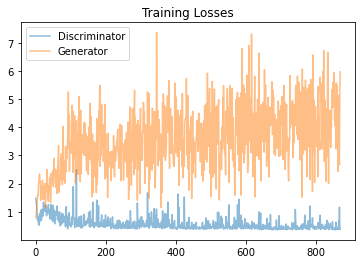

In [49]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)  
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [50]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [51]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

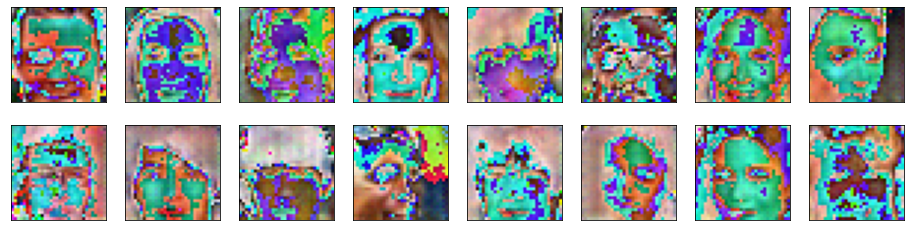

In [52]:
_ = view_samples(-1, samples)

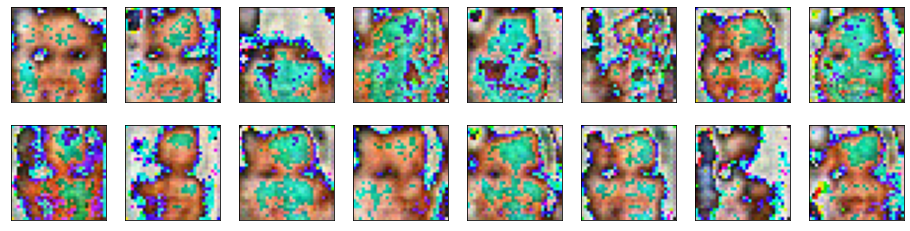

In [53]:
_ = view_samples(0, samples)

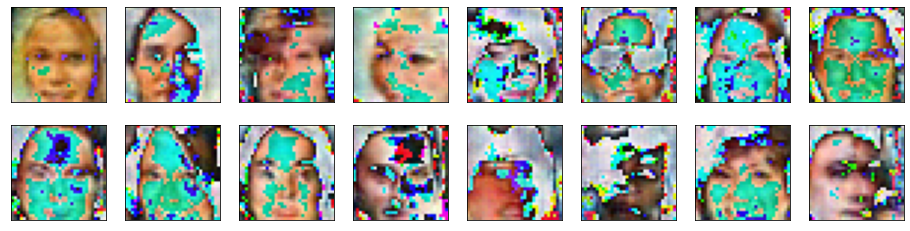

In [54]:
_ = view_samples(5, samples)

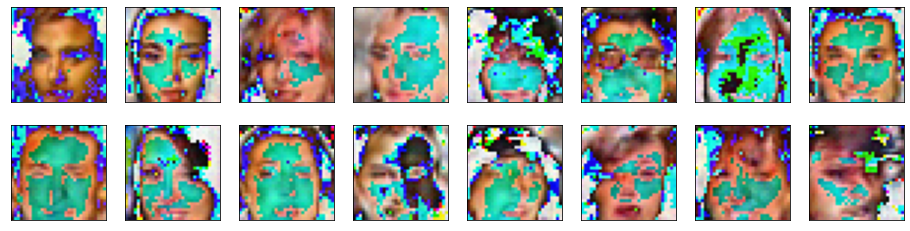

In [55]:
_ = view_samples(10, samples)

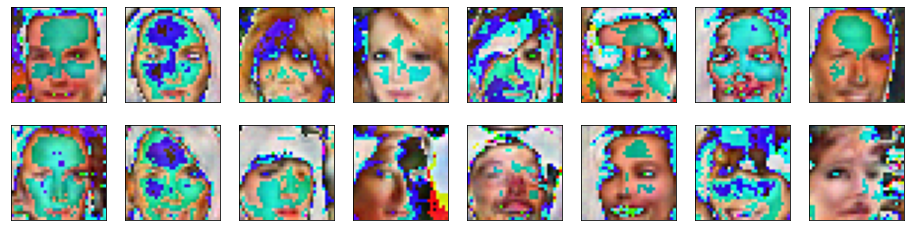

In [56]:

_ = view_samples(15, samples)

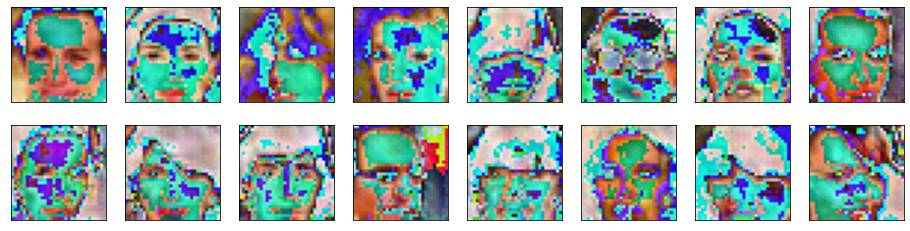

In [57]:
_ = view_samples(20, samples)

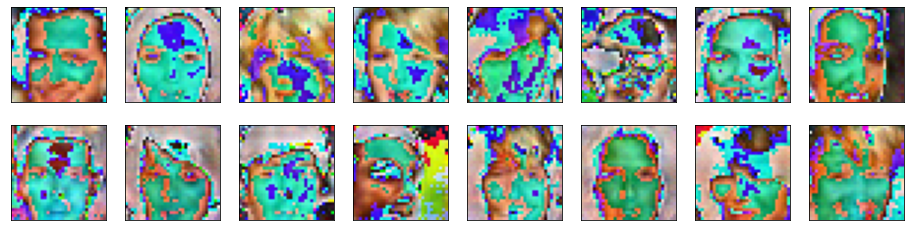

In [58]:
_ = view_samples(25, samples)

IndexError: list index out of range

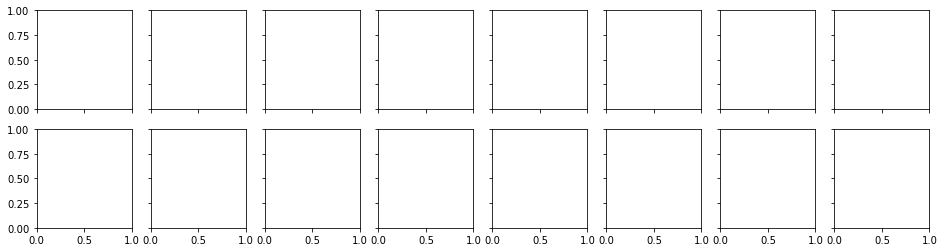

In [59]:
_ = view_samples(30, samples)

In [ ]:
_ = view_samples(35, samples)

In [ ]:
_ = view_samples(40, samples)

In [ ]:
_ = view_samples(45, samples)

In [ ]:
_ = view_samples(50, samples)

In [ ]:
_ = view_samples(55, samples)

In [ ]:
_ = view_samples(65, samples)

In [ ]:
_ = view_samples(75, samples)

In [ ]:
_ = view_samples(85, samples)

In [ ]:
_ = view_samples(95, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result

**Answer:** 
After implementing:
- using smooth labels for real loss 
the training went much more smoother and the generator loss never went too high. The results also looks really acceptable after only 5 epochs which is quite impressive.
I also implemented xavier for weight initialization.

encouraged by the previous results I wanted to go a little further and follow some of the suggestion to improve the the GAN perfomrmance as came in the original paper titled "Improved Techniques for Training GANs"

- I added extra layer in the discriminator and implemented Dropout2D and the results were:

I think after making the generator deeper with dropout and witnessing the GAN perfoming worst, is that making the discriminator deeper and adding dropout layer to it will actually stabelize the GAN better because the generator actually depends on the discriminator training (it will recieve more information to generate usefull data). I could be wrong and will try to do some further testing


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

## Things to watch out for during training:
- D loss goes to 0: failure mode
- check norms of gradients: if they are over 100 things are screwing up
- when things are working, D loss has low variance and goes down over time vs having huge variance and spiking
- if loss of generator steadily decreases, then it's fooling D with garbage (says martin)

**Other notes from Deepak Mehra**

- If the d_loss approaches 0 and keeps on close to 0 always while G_loss increase then GAN is failing.
- If the G_Loss keeps on increasing while D_loss stays in between from 0 -1 then model is failing
- If the g_loss stays constant and no fluctuation for a while then the model is going in a problem called Mode   Collapse
- G_loss should be higher than d_loss always.
